In [3]:
import numpy as np
from pathlib import Path

p = "../diffusion_model/run_2/condition_2.npz"
if not Path(p).exists(): raise FileNotFoundError(p)

z = np.load(p, allow_pickle=True)
    
print("keys:", z.files)
for k in z.files:
    v = z[k]
    if isinstance(v, np.ndarray) and v.dtype == object and v.shape == ():
        o = v.item()
        if isinstance(o, dict): print(k, "->", list(o.keys()))
    elif isinstance(v, dict):
        print(k, "->", list(v.keys()))
    elif isinstance(v, np.ndarray) and v.dtype == object:
        for i, e in enumerate(v.flat):
            if isinstance(e, dict): print(f"{k}[{i}] ->", list(e.keys()))


keys: ['bundle']
bundle -> ['input', 'target', 'output', 'meta']


In [4]:
input = z['bundle'].item()['input']
target = z['bundle'].item()['target']
output = z['bundle'].item()['output']
meta = z['bundle'].item()['meta']

In [5]:
input.shape, target.shape, output.shape, meta

((5,),
 (3, 32, 32),
 (200, 3, 32, 32),
 {'condition_index': 2, 'num_generated': 200, 'num_samples_requested': 200})

In [6]:
bundle_dict = z['bundle'].item()

In [11]:
target.min(), target.max()

(np.float32(0.0), np.float32(1.0))

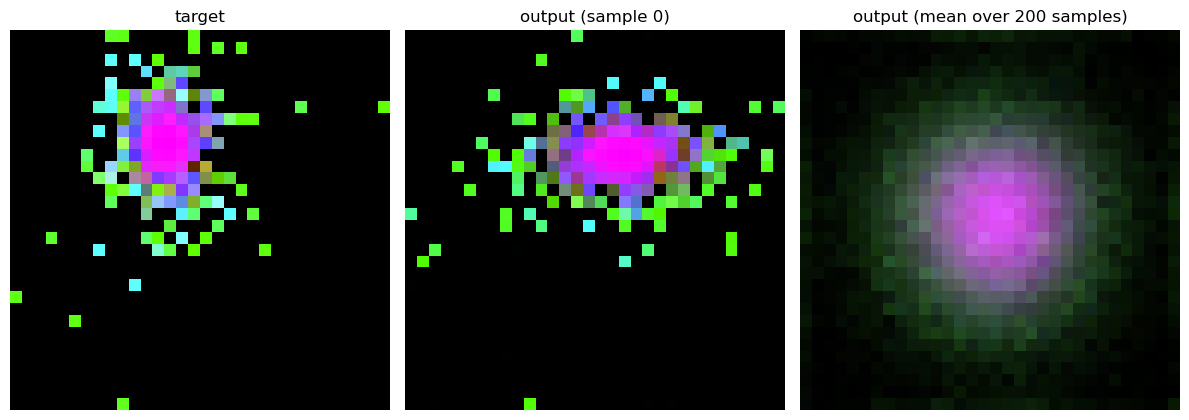

In [12]:
import matplotlib.pyplot as plt

# plot output and target values as 3 color images
def hwc_from_chw(x):
    # x: (3, H, W) -> (H, W, 3)
    return np.transpose(x, (1, 2, 0))

def normalize01(img):
    mn, mx = img.min(), img.max()
    if mx > mn:
        return (img - mn) / (mx - mn)
    return img - mn  # all zeros case

target_img = normalize01(hwc_from_chw(target))

# pick the first generated sample to display
out_img0 = normalize01(hwc_from_chw(output[0]))
out_img_mean = normalize01(hwc_from_chw(output.mean(axis=0)))

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(target_img)
axs[0].set_title("target")
axs[0].axis("off")

axs[1].imshow(out_img0)
axs[1].set_title("output (sample 0)")
axs[1].axis("off")

axs[2].imshow(out_img_mean)
axs[2].set_title("output (mean over 200 samples)")
axs[2].axis("off")

plt.tight_layout()


In [13]:
from scipy.ndimage import gaussian_filter

def plot_output_samples(output_arr, n=20, cols=5, apply_gaussian=True, gaussian_sigma=1.0, figsize_scale=2.5):
    """Plot first n outputs from output_arr (shape: N, C, H, W) as RGB images."""
    n = min(n, output_arr.shape[0])
    cols = max(1, cols)
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * figsize_scale, rows * figsize_scale))
    axs = np.array(axs).reshape(-1)

    for i in range(rows * cols):
        if i < n:
            tensor = output_arr[i].copy()  # (C, H, W)
            if apply_gaussian:
                for ch in range(tensor.shape[0]):
                    tensor[ch] = gaussian_filter(tensor[ch], sigma=gaussian_sigma)
            img = normalize01(hwc_from_chw(tensor))
            axs[i].imshow(img)
            axs[i].set_title(f"sample {i}")
            axs[i].axis("off")
        else:
            axs[i].axis("off")

    plt.tight_layout()
    return fig, axs


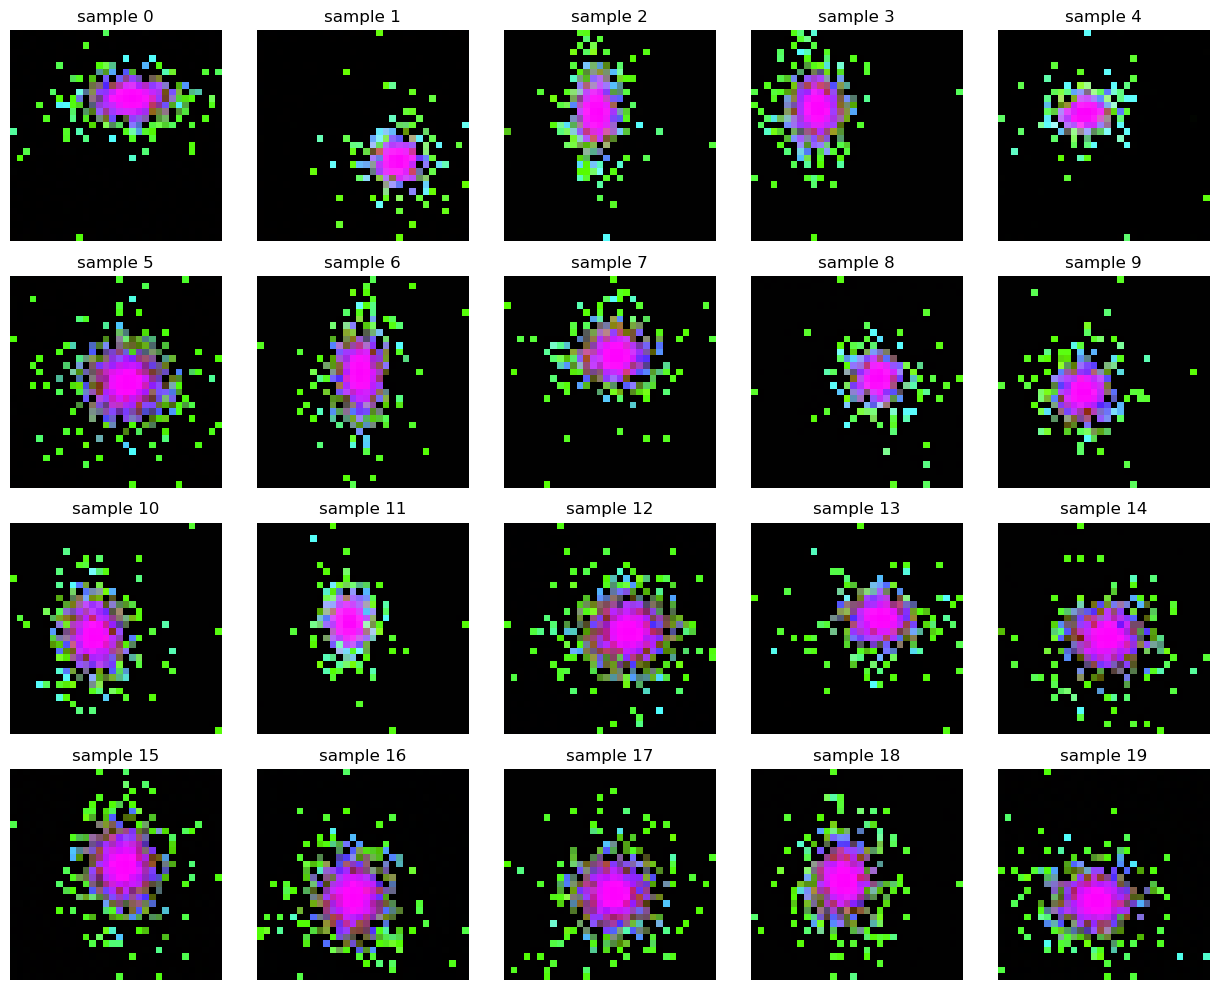

In [14]:
fig, axs = plot_output_samples(output, n=20, cols=5, apply_gaussian=False, gaussian_sigma=1.0)

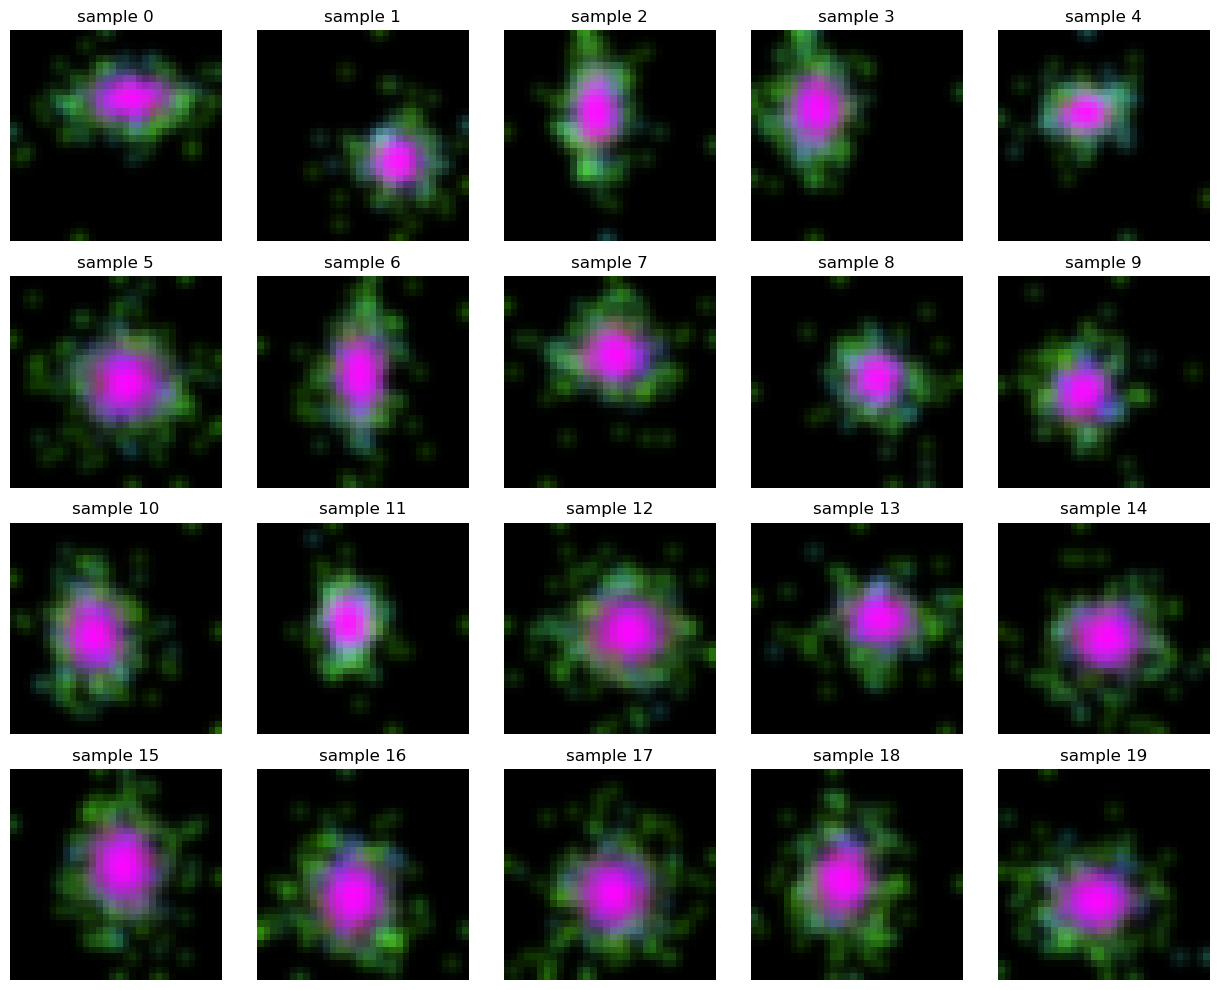

In [15]:
fig, axs = plot_output_samples(output, n=20, cols=5, apply_gaussian=True, gaussian_sigma=1.0)

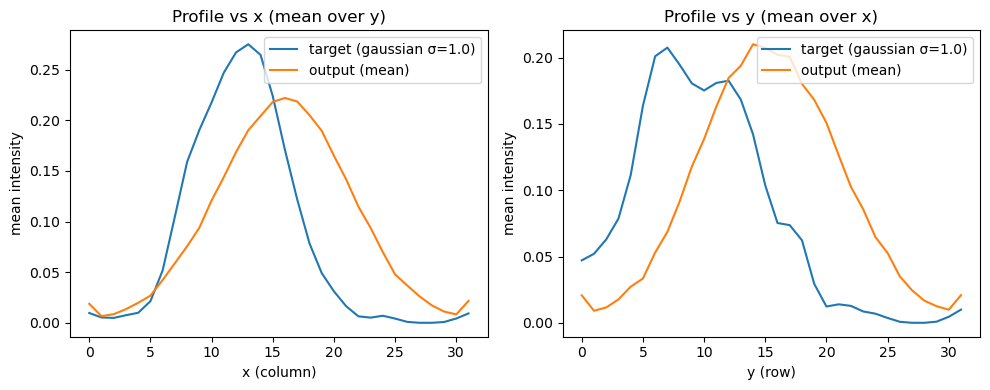

In [17]:
# apply gaussian to target channels before plotting
gaussian_sigma = 1.0

target_blur = target.copy()
for ch in range(target_blur.shape[0]):
    target_blur[ch] = gaussian_filter(target_blur[ch], sigma=gaussian_sigma)

# compute mean image over samples and convert to grayscale (mean over channels)
output_mean = output.mean(axis=0)  # (3, H, W)
def chw_to_gray(chw):
    return chw.mean(axis=0)  # (H, W)

t_gray = chw_to_gray(target_blur)
o_gray = chw_to_gray(output_mean)

# mean profiles: mean over rows -> profile vs x (columns), mean over cols -> profile vs y (rows)
x_prof_t = t_gray.mean(axis=0)
x_prof_o = o_gray.mean(axis=0)
y_prof_t = t_gray.mean(axis=1)
y_prof_o = o_gray.mean(axis=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.arange(t_gray.shape[1]), x_prof_t, label=f'target (gaussian σ={gaussian_sigma})')
axs[0].plot(np.arange(o_gray.shape[1]), x_prof_o, label='output (mean)')
axs[0].set_xlabel('x (column)')
axs[0].set_ylabel('mean intensity')
axs[0].set_title('Profile vs x (mean over y)')
axs[0].legend()

axs[1].plot(np.arange(t_gray.shape[0]), y_prof_t, label=f'target (gaussian σ={gaussian_sigma})')
axs[1].plot(np.arange(o_gray.shape[0]), y_prof_o, label='output (mean)')
axs[1].set_xlabel('y (row)')
axs[1].set_ylabel('mean intensity')
axs[1].set_title('Profile vs y (mean over x)')
axs[1].legend()

plt.tight_layout()